In [ ]:
from skimage import io
import json
my_img = io.imread(r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\ffba62c94141.jpg')
io.imshow(my_img)
io.show()
j = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations\ffba62c94141.json'
f = open(j)
data = json.load(f)
f.close()

In [ ]:
data

In [ ]:
path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'
json_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations'
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.nn import functional
import json
import pandas as pd

bsize=256

img_names = os.listdir(path)
#json_names = os.listdir(json_path)
i=0
#ADD TRAIN TEST SPLIT HERE TO IMG_NAMES
from sklearn.model_selection import train_test_split
train, test = train_test_split(img_names, test_size=0.1, random_state=5)

images = np.empty(shape = (bsize, 3, 256, 256))
labels = np.chararray(bsize, itemsize=20)
for idx, name in enumerate(img_names):
    if (i==bsize):
        break
    img_name = path + '\\' + name
    json_name = json_path + '\\' + name
    json_name = json_name.replace(json_name[len(json_name) - 3:], 'json')
    # Use you favourite library to load the image
    image = plt.imread(img_name)
    image = image.copy()
    image = torch.from_numpy(image)
    image = torch.unsqueeze(image, dim=0)
    image = torch.movedim(image, source=3, destination=1)
    image = functional.interpolate(image, size = (256,256))
    
    f = open(json_name)
    data = json.load(f)
    t = data['chart-type']
    images[idx] = image
    labels[idx] = t
    f.close()
    
    #image_resized = functional.interpolate(image, size = (128,128))
    i+=1

In [ ]:
images.shape

In [ ]:
#my_img=images[45]
io.imshow(my_img)
io.show()

In [ ]:
#labels

In [ ]:
efnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
efnet_model = torchvision.models.efficientnet_b0(weights = efnet_weights)

In [ ]:
## Loop through each parameter and set `requires_grad` to false
for param in efnet_model.features.parameters():
    param.requires_grad = False

In [ ]:
## Replace the "classifier" layer with one for our application
efnet_model.classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features=1280, out_features=4, bias=True))

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from pandas import get_dummies

train_y=labels
train_X=images

encode_list = [b'vertical_bar',b'scatter',b'dot',b'line']
# Create an instance of the OneHotEncoder class and fit it on the data
encoder = OneHotEncoder(sparse=False)
encoder.fit(train_y.reshape(-1, 1))

# Transform the data using the fitted encoder
encoded_data = encoder.transform(train_y.reshape(-1, 1))

# Map the encoded data to the desired format
train_y = [encoder.categories_[0].tolist().index(category) for category in encoder.inverse_transform(encoded_data).flatten()]

print(train_y)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

y_tensor = torch.tensor(train_y)

### Convert to numpy array then reshape to 900 by 28 by 28
mnist_unflattened = train_X
mnist_unflattened = mnist_unflattened.reshape(256, 3, 256, 256)

## Convert to tensor
mnist_tensor = torch.from_numpy(mnist_unflattened)
mnist_tensor =  torch.unsqueeze(mnist_tensor, dim=1)

## Transform to proper input shape
new_mnist_tensors = mnist_tensor.expand(-1, -1, -1, -1, -1)

train_loader = DataLoader(TensorDataset(new_mnist_tensors.type(torch.FloatTensor), y_tensor.type(torch.LongTensor)), batch_size=32)

In [ ]:
## Hyperparms
epochs = 100
lrate = 0.1

## Cost Function
from torch import nn
cost_fn = nn.NLLLoss()

## Network model
torch.manual_seed(7) # For reproduction purposes (should be minor since only the last layers are randomly intialized)
net = efnet_model

## Optimizer (using ADAM, a more flexible algorithm than SGD this time)
optimizer = torch.optim.Adam(net.parameters(), lr=lrate)

## Initial values for cost tracking
track_cost = np.zeros(epochs)
cur_cost = 0.0

## Loop through the data
for epoch in range(epochs):
    
    cur_cost = 0.0
    correct = 0.0
    
    ## train_loader is iterable and numbers knows the batch
    for i, data in enumerate(train_loader, 0):
        
        ## The input tensor and labels tensor for the current batch
        inputs, labels = data
        ## Clear the gradient from the previous batch
        optimizer.zero_grad()
        
        ## Provide the input tensor into the network to get outputs
        inputs = inputs.reshape((32, 3, 256, 256))
        outputs = net(inputs)
        
        ## Calculate the cost for the current batch
        cost = cost_fn(outputs.log_softmax(dim=1), labels)
        
        ## Calculate the gradient
        cost.backward()
        
        ## Update the model parameters using the gradient
        optimizer.step()
        
        ## Track the current cost (accumulating across batches)
        cur_cost += cost.item()
    
    ## Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    print(f"Epoch: {epoch} Cost: {cur_cost}") ## Uncomment this if you want printed updates


In [ ]:
#Take 2

In [ ]:
path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'
json_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations'
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.nn import functional
import json
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from pandas import get_dummies

bsize=256

img_names = os.listdir(path)
#img_name = path + '\\' + name
#json_names = os.listdir(json_path)
i=0
#ADD TRAIN TEST SPLIT HERE TO IMG_NAMES
from sklearn.model_selection import train_test_split
train, test = train_test_split(img_names, test_size=0.999, random_state=5)

images = np.empty(shape = (bsize, 3, 256, 256))
labels = np.chararray(bsize, itemsize=20)

In [ ]:
train_y = train.copy()
train_X = train.copy()
for i in range(len(train)):
    train_X[i] = path + '\\' + img_names[i]
    train_y[i] = json_path + '\\' + img_names[i]
    train_y[i] = train_y[i].replace(train_y[i][len(train_y[i]) - 3:], 'json')

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [ ]:
class MyDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        f = open(self.label_paths[index])
        data = json.load(f)
        t = data['chart-type']
        #print(t)
        if (t=='scatter'):
            label = 0
        elif (t=='vertical_bar'):
            label = 1
        elif (t=='dot'):
            label = 2
        else:
            label = 3
        f.close()
        
        if self.transform:
            image = self.transform(image)
            #label = self.transform(label)
            
        return image, label

# Define the transform to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create a dataset from the image and label file paths
dataset = MyDataset(train_X, train_y, transform=transform)

# Create a dataloader to load the data in batches
batch_size = 256
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
efnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
efnet_model = torchvision.models.efficientnet_b0(weights = efnet_weights)
## Loop through each parameter and set `requires_grad` to false
for param in efnet_model.features.parameters():
    param.requires_grad = False

## Replace the "classifier" layer with one for our application
efnet_model.classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features=1280, out_features=4, bias=True))

In [ ]:
#encoder = OneHotEncoder(sparse=False)

# Train the neural network on the data using batches
from torch import nn
epochs = 1
lrate = 0.1
cost_fn = nn.NLLLoss()
net = efnet_model
optimizer = torch.optim.Adam(net.parameters(), lr=lrate)
track_cost = np.zeros(epochs)

for epoch in range(epochs):
    cur_cost = 0.0
    correct = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        inputs = inputs.reshape(inputs.size())
        outputs = net(inputs)
        #print(labels)
        
        cost = cost_fn(outputs.log_softmax(dim=1), labels)
        cost.backward()
        optimizer.step()
        cur_cost += cost.item()
        
    track_cost[epoch] = cur_cost
    print(f"Epoch: {epoch} Cost: {cur_cost}")

In [ ]:
#ADD TEST CODE TO MAKE SURE IT WORKS
test_y = test.copy()
test_X = test.copy()
i=0
for i in range(len(test)):
    test_X[i] = path + '\\' + img_names[i]
    test_y[i] = json_path + '\\' + img_names[i]
    test_y[i] = test_y[i].replace(test_y[i][len(test_y[i]) - 3:], 'json')

In [ ]:
dataset = MyDataset(test_X, test_y, transform=transform)

# Create a dataloader to load the data in batches
batch_size = 256
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# set model to evaluation mode
#net.eval()

# iterate through test data and generate predictions
#with torch.no_grad():
    #predicted = []
    #for data in test_loader:
        #inputs, _ = data
        #inputs = inputs.reshape(inputs.size())
        #outputs = net(inputs)
        #_, pred = torch.max(outputs.data, 1)
        #predicted.append(pred.numpy())

# convert predicted labels to numpy array
#predicted = np.concatenate(predicted)


In [ ]:
#predicted

In [ ]:
# set model to evaluation mode
net.eval()

# iterate through test data and generate predictions
with torch.no_grad():
    predicted = []
    actual = []
    for data in test_loader:
        inputs, labels = data
        #inputs = inputs.reshape(inputs.size())
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        predicted.append(pred.numpy())
        actual.append(labels.numpy())
        print(pred)
        print(labels)
        if (pred != labels):
            print(inputs)

# concatenate predicted and actual labels
predicted = np.concatenate(predicted)
actual = np.concatenate(actual)

# compute accuracy
accuracy = np.mean(predicted == actual)
print(accuracy)


In [ ]:
j = json_path + '\\' + '18a1ca02e41e.json'

In [ ]:
j = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations\ffba62c94141.json'
f = open(j)
data = json.load(f)

In [ ]:
data['axes']

In [ ]:
data['data-series']

In [ ]:
f.close()

In [ ]:
j = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations\ff71f98c2b6d.json'
f = open(j)
data = json.load(f)
f.close()

In [ ]:
#data

In [ ]:
data['data-series']

In [ ]:
len(data['data-series'])

In [ ]:
data['data-series']

In [ ]:
x = "x,"
for i in range(len(data['data-series'])):
    x += str(data['data-series'][i]['x'])
    x += ";"
x=x[:-1] + ', ' + data['chart-type']

In [ ]:
x

In [ ]:
y = "y,"
for i in range(len(data['data-series'])):
    y += str(data['data-series'][i]['y'])
    y += ";"
y=y[:-1] + ', ' + data['chart-type']

In [ ]:
y

In [ ]:
output = x + "\n" + y
output

In [ ]:
data['text'][3]['text']

In [ ]:
len(data['text'])

In [ ]:
data

In [ ]:
ylab = ""
xlab = ""
xcoord = data['text'][3]['polygon']['x0']
for i in range(3, len(data['text'])):
    if (data['text'][i]['polygon']['x0'] - xcoord < 5):
        ylab = ylab + data['text'][i]['text'] + ";"
    else:
        xlab = xlab + data['text'][i]['text'] + ";"

In [ ]:
xlab

In [ ]:
ylab

In [ ]:
xlab = ""
for i in range(int((len(data['text'])-3)/2), len(data['text'])):
    xlab = xlab + data['text'][i]['text'] + ";"

In [ ]:
xlab

In [ ]:
efnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
efnet_model = torchvision.models.efficientnet_b0(weights = efnet_weights)

In [ ]:
efnet_model

In [ ]:
#encoder = OneHotEncoder(sparse=False)

# Train the neural network on the data using batches
from torch import nn
epochs = 100
lrate = 0.1
cost_fn = nn.NLLLoss()
net = efnet_model
optimizer = torch.optim.Adam(net.parameters(), lr=lrate)
track_cost = np.zeros(epochs)

for epoch in range(epochs):
    cur_cost = 0.0
    correct = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        inputs = inputs.reshape(inputs.size())
        outputs = net(inputs)
        #print(labels)
        
        cost = cost_fn(outputs.log_softmax(dim=1), labels)
        cost.backward()
        optimizer.step()
        cur_cost += cost.item()
        
    track_cost[epoch] = cur_cost
    print(f"Epoch: {epoch} Cost: {cur_cost}")

In [ ]:
#take 3 v2 easyocr HERE GOOD

In [ ]:
path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'
json_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations'
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.nn import functional
import json
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from pandas import get_dummies
from skimage import io

bsize=256

img_names = os.listdir(path)
#img_name = path + '\\' + name
#json_names = os.listdir(json_path)
i=0
#ADD TRAIN TEST SPLIT HERE TO IMG_NAMES
from sklearn.model_selection import train_test_split
train, test = train_test_split(img_names, test_size=0.99, random_state=5)

images = np.empty(shape = (bsize, 3, 256, 256))
labels = np.chararray(bsize, itemsize=20)

In [ ]:
train_y = train.copy()
train_X = train.copy()
for i in range(len(train)):
    train_X[i] = path + '\\' + img_names[i]
    train_y[i] = json_path + '\\' + img_names[i]
    train_y[i] = train_y[i].replace(train_y[i][len(train_y[i]) - 3:], 'json')

In [ ]:
#pip install opencv-python==4.5.5.64

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import easyocr
import matplotlib.pyplot as plt

In [ ]:
class MyDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        image = image.convert('L')
        f = open(self.label_paths[index])
        data = json.load(f)
        t = data['chart-type']
        #print(t)
        if (t=='scatter'):
            label = 0
        elif (t=='vertical_bar'):
            label = 1
        elif (t=='dot'):
            label = 2
        else:
            label = 3
        ylab = ""
        xlab = ""
        xcoord = data['text'][3]['polygon']['x0']
        for i in range(3, len(data['text'])):
            if (data['text'][i]['polygon']['x0'] - xcoord < 5):
                ylab = ylab + data['text'][i]['text'] + ";"
            else:
                xlab = xlab + data['text'][i]['text'] + ";"
        print(xlab)
        print(ylab)
        f.close()
        
        if self.transform:
            image = self.transform(image)
            #label = self.transform(label)
            #print(label)
            
        return image, label

# Define the transform to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create a dataset from the image and label file paths
dataset = MyDataset(train_X, train_y, transform=transform)

# Create a dataloader to load the data in batches
batch_size = 256
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#my_img = Image.open(r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\ffba62c94141.jpg')
#image = my_img.convert('L')
#image.show()
#io.imshow(my_img)
#io.show()

In [ ]:
img = cv2.imread(r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\ffdad4a3bb09.jpg')

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\ffdad4a3bb09.jpg')

In [ ]:
result

In [ ]:
for detection in result:
    text = detection[1]
    plt.text(detection[0][0][0], detection[0][0][1], text, fontsize=12, color='r')
plt.imshow(img)
plt.show()

In [ ]:
result

In [ ]:
#keras

In [ ]:
path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'
json_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations'
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.nn import functional
import json
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from pandas import get_dummies
from skimage import io

bsize=256

img_names = os.listdir(path)
#img_name = path + '\\' + name
#json_names = os.listdir(json_path)
i=0
#ADD TRAIN TEST SPLIT HERE TO IMG_NAMES
from sklearn.model_selection import train_test_split
train, val = train_test_split(img_names, test_size=0.99, random_state=5)

images = np.empty(shape = (bsize, 3, 256, 256))
labels = np.chararray(bsize, itemsize=20)

In [ ]:
y_train = train.copy()
X_train = train.copy()
for i in range(len(train)):
    X_train[i] = path + '\\' + img_names[i]
    y_train[i] = json_path + '\\' + img_names[i]
    y_train[i] = y_train[i].replace(y_train[i][len(y_train[i]) - 3:], 'json')

In [ ]:
y_val = val.copy()
X_val = val.copy()
for i in range(len(train)):
    X_val[i] = path + '\\' + img_names[i]
    y_val[i] = json_path + '\\' + img_names[i]
    y_val[i] = y_val[i].replace(y_val[i][len(y_val[i]) - 3:], 'json')

In [ ]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense

# Define the MLP model
model = Sequential()
model.add(Dense(32, input_dim=16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss = model.evaluate(X_test, y_test)

# Use the model to make predictions
predictions = model.predict(X_new)


In [ ]:
#TRAINING EASYOCR

In [ ]:
path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'
json_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations'
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.nn import functional
import json
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from pandas import get_dummies
from skimage import io

bsize=256

img_names = os.listdir(path)
#img_name = path + '\\' + name
#json_names = os.listdir(json_path)
i=0
#ADD TRAIN TEST SPLIT HERE TO IMG_NAMES
from sklearn.model_selection import train_test_split
train, test = train_test_split(img_names, test_size=0.99, random_state=5)

images = np.empty(shape = (bsize, 3, 256, 256))
labels = np.chararray(bsize, itemsize=20)

In [ ]:
j = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations\ffcaa8fb17b3.json'
f = open(j)
data = json.load(f)
f.close()

In [ ]:
data['text'][1]

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import easyocr
import matplotlib.pyplot as plt

In [ ]:
img = cv2.imread(r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\ffdad4a3bb09.jpg')

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\ffdad4a3bb09.jpg')
for detection in result:
    text = detection[1]
    plt.text(detection[0][0][0], detection[0][0][1], text, fontsize=12, color='r')
plt.imshow(img)
plt.show()

In [ ]:
result

In [ ]:
import easyocr

custom_model = easyocr.Reader(['en'], gpu=False)

In [ ]:
import easyocr
import os
import json

ann = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations'
# Set up the directory paths and file names
train_folder = r'C:\Users\16032\Downloads\images-test\images'
gt_folder = r'C:\Users\16032\Downloads\images-test\txts'

# Create a list of dictionaries containing the image file paths and associated labels
datas = []

l = os.listdir(train_folder)

for filename in l:
    file_name = filename[:-3] + 'txt'
    if filename.endswith('.jpg'):
        info = []
        image_path = os.path.join(train_folder, filename)
        txt_path = os.path.join(gt_folder, filename[:-3] + 'txt')
        j = ann + '\\' + filename
        j = j[:-3] + 'json'
        with open(j) as f:
            data = json.load(f)
            #print(data)
        f.close()
        result = txt_path + "\n"
        for i in range(len(data['text'])):
            # Create the file in the specified directory and write the text to it
            file_text = [[[data['text'][i]['polygon']['x0'], data['text'][i]['polygon']['y0']], 
               [data['text'][i]['polygon']['x1'], data['text'][i]['polygon']['y1']],
               [data['text'][i]['polygon']['x2'], data['text'][i]['polygon']['y2']],
               [data['text'][i]['polygon']['x3'], data['text'][i]['polygon']['y3']],
               data['text'][i]['text']]]
            for sublist in file_text:
                result += "(" + str(sublist) + ")"
            result = result + "\n"
        with open(txt_path, 'w') as f:
            f.write(result)
        datas.append({'image_path': image_path, 'label': txt_path})


In [ ]:
data['text'][1]['text']

In [ ]:
data['text'][2]['text']

In [ ]:
import easyocr

reader = easyocr.Reader(['en'], gpu=False)


In [ ]:
#WE HERE NOW

In [ ]:
import torch.nn as nn

class BidirectionalLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input):
        """
        input : visual feature [batch_size x T x input_size]
        output : contextual feature [batch_size x T x output_size]
        """
        try: # multi gpu needs this
            self.rnn.flatten_parameters()
        except: # quantization doesn't work with this 
            pass
        recurrent, _ = self.rnn(input)  # batch_size x T x input_size -> batch_size x T x (2*hidden_size)
        output = self.linear(recurrent)  # batch_size x T x output_size
        return output

class VGG_FeatureExtractor(nn.Module):

    def __init__(self, input_channel, output_channel=256):
        super(VGG_FeatureExtractor, self).__init__()
        self.output_channel = [int(output_channel / 8), int(output_channel / 4),
                               int(output_channel / 2), output_channel]
        self.ConvNet = nn.Sequential(
            nn.Conv2d(input_channel, self.output_channel[0], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(self.output_channel[0], self.output_channel[1], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(self.output_channel[1], self.output_channel[2], 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(self.output_channel[2], self.output_channel[2], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(self.output_channel[2], self.output_channel[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.output_channel[3]), nn.ReLU(True),
            nn.Conv2d(self.output_channel[3], self.output_channel[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.output_channel[3]), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(self.output_channel[3], self.output_channel[3], 2, 1, 0), nn.ReLU(True))

    def forward(self, input):
        return self.ConvNet(input)

class Model(nn.Module):

    def __init__(self, input_channel, output_channel, hidden_size, num_class):
        super(Model, self).__init__()
        """ FeatureExtraction """
        self.FeatureExtraction = VGG_FeatureExtractor(input_channel, output_channel)
        self.FeatureExtraction_output = output_channel
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool2d((None, 1))

        """ Sequence modeling"""
        self.SequenceModeling = nn.Sequential(
            BidirectionalLSTM(self.FeatureExtraction_output, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, hidden_size))
        self.SequenceModeling_output = hidden_size

        """ Prediction """
        self.Prediction = nn.Linear(self.SequenceModeling_output, num_class)


    def forward(self, input, text):
        """ Feature extraction stage """
        visual_feature = self.FeatureExtraction(input)
        visual_feature = self.AdaptiveAvgPool(visual_feature.permute(0, 3, 1, 2))
        visual_feature = visual_feature.squeeze(3)

        """ Sequence modeling stage """
        contextual_feature = self.SequenceModeling(visual_feature)

        """ Prediction stage """
        prediction = self.Prediction(contextual_feature.contiguous())

        return prediction


In [ ]:
model = Model(input_channel=3, output_channel=64, hidden_size=256, num_class=10)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # Load the image and label data
        image_path = self.data[index]['image_path']
        label_path = self.data[index]['label']
        image = Image.open(image_path).convert('RGB')
        with open(label_path, 'r') as f:
            label = f.read().strip()
        
        # Apply the transforms to the image
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label


In [ ]:
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Define the training parameters
batch_size = 32
num_epochs = 10
lr = 0.001
momentum = 0.9

# Define the transform to be applied to the images
transform = transforms.Compose([
    transforms.Resize((32, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset and dataloader
train_data = CustomDataset(datas, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Define the device to be used for training
device = "cpu"

# Initialize the model and optimizer
model = Model(input_channel=3, output_channel=256, hidden_size=256, num_class=10)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        #print(inputs)
        inputs = inputs.to(device)
        labels = torch.tensor(labels).to(device)  # convert labels to tensor
        optimizer.zero_grad()
        outputs = model(inputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx+1, len(train_loader),
                100. * batch_idx / len(train_loader), loss.item()))

print('Finished Training')


In [ ]:
labels.split("\n")

In [ ]:
labels[0]

In [ ]:
train_loader

In [ ]:
train_data

In [ ]:
datas

In [ ]:
#tesseract

In [ ]:
import pytesseract

In [ ]:
# Read image from file
img = Image.open(r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\ffd4b06df6fd.jpg')

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\16032\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
text = pytesseract.image_to_string(img)

In [ ]:
print(text)

In [ ]:
#KAGGLE

In [ ]:
import os
import json
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
# Load images
images_path = r"C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images"
images = []
for file in os.listdir(images_path):
    img = cv2.imread(os.path.join(images_path, file), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
    images.append(img)

In [ ]:
# Load annotations
annotations_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations'
annotations = []
for file in os.listdir(images_path):
    file = file[:-3] + "json"
    with open(os.path.join(annotations_path, file)) as f:
        annotations.append(json.load(f))

In [ ]:
# Preprocess data
X = np.array(images)#.reshape(-1, 128, 128, 1)
y = [annotation['data-series'] for annotation in annotations]

In [ ]:
data

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='linear')  # Predict X and Y coordinates
])

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
import tensorflow as tf
Xtrain = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
test_images_path = "test/images/"
test_images = []
for file in os.listdir(test_images_path):
    img = cv2.imread(os.path.join(test_images_path, file), cv2.IMREAD_GRAYSCALE)
    test_images.append(img)

X_test = np.array(test_images).reshape(-1, 128, 128, 1) / 255.0
predictions = model.predict(X_test)

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['data-series'] = predictions.tolist()
submission.to_csv('submission.csv', index=False)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load your precollected data
X = X_train # Array with input features (x and y coordinates)
y = y_train # Array with output labels (the predicted location of points)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLP model
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
model.fit(X_train, y_train)

# Evaluate the performance of the model on the testing set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: {:.2f}".format(mse))


In [ ]:
j = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations\ffba62c94141.json'
f = open(j)
data = json.load(f)

In [ ]:
data['visual-elements']['scatter points']

In [ ]:
data['axes']['x-axis']['ticks'][i]['tick_pt']['x']

In [ ]:
pts = []
for i in range (len(data['axes']['x-axis']['ticks'])):
    pts = pts + [[data['axes']['x-axis']['ticks'][i]['tick_pt']['x'], data['axes']['x-axis']['ticks'][i]['tick_pt']['y']]]

In [ ]:
pts

In [ ]:
import os
import json
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
# Load images
images_path = r"C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images"
images = []
for file in os.listdir(images_path):
    img = cv2.imread(os.path.join(images_path, file), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
    images.append(img)

In [ ]:
# Load annotations
annotations_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations'
annotations = []
for file in os.listdir(images_path):
    file = file[:-3] + "json"
    with open(os.path.join(annotations_path, file)) as f:
        json.load(f)
        pts = []
        for i in range (len(data['axes']['x-axis']['ticks'])):
            pts = pts + [[data['axes']['x-axis']['ticks'][i]['tick_pt']['x'], data['axes']['x-axis']['ticks'][i]['tick_pt']['y']]]
        annotations.append(json.load(f))

In [ ]:
#5/9

In [ ]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
image_path = r'C:\Users\16032\Downloads\images-test\images'
dir_Flickr_text = r'C:\Users\16032\Downloads\images-test\txts'
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))
ann = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations'

In [ ]:
import json
image_path = r'C:\Users\16032\Downloads\images-test\images'
l = os.listdir(image_path)
datas = []
result = ""
i=0

for filename in l:
    file_name = "info.txt"
    #print(file_name)
    if filename.endswith('.jpg'):
        info = []
        image_path = os.path.join(filename)
        txt_path = os.path.join(dir_Flickr_text, "info.txt")
        j = ann + '\\' + filename
        j = j[:-3] + 'json'
        with open(j) as f:
            data = json.load(f)
            #print(data)
        f.close()
        result += image_path + "#" + str(i) + "\t"
        # Create the file in the specified directory and write the text to it
        file_text = data['text'][0]['text']
        #print(file_text)
        result += file_text
        result = result + "\n"
        i+=1
with open(txt_path, 'w') as f:
    f.write(result)
#datas.append({'image_path': image_path, 'label': txt_path})

In [ ]:
file = open(os.path.join(dir_Flickr_text, "info.txt"),'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

In [ ]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1
image_path = r'C:\Users\16032\Downloads\images-test\images'

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '\\' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)#.Resizing(128,128,interpolation='bilinear',crop_to_aspect_ratio=False,**kwargs)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [ ]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

In [ ]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

In [ ]:
PATH = r'C:\Users\16032\Downloads\images-test\images'
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

In [ ]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + "\\" + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
    train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(256,all_captions,all_img_name_vector)

In [ ]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

In [ ]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
%%time
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

In [ ]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
train_captions[:3]

In [ ]:
train_seqs[:3]

In [ ]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [ ]:
BATCH_SIZE = 12
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [ ]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class VGG16_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [ ]:
def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [ ]:
class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [ ]:
EPOCHS = 20
start_epoch = 1
for epoch in range(start_epoch, EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\ffba62c94141.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'Total Army Personal In Middle East & North Africa (Excluding High Income)'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

In [ ]:
#refined version

In [1]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
image_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'
dir_Flickr_text = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\text'
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))
ann = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\annotations'

Total Images in Dataset = 120338


In [3]:
import json
image_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'
l = os.listdir(image_path)
datas = []
result = ""
i=0

for filename in l:
    file_name = "info.txt"
    #print(file_name)
    if filename.endswith('.jpg'):
        info = []
        image_path = os.path.join(filename)
        txt_path = os.path.join(dir_Flickr_text, "info.txt")
        j = ann + '\\' + filename
        j = j[:-3] + 'json'
        with open(j, encoding="utf-8") as f:
            data = json.load(f)
            #print(data)
        f.close()
        result += image_path + "#" + str(i) + "\t"
        # Create the file in the specified directory and write the text to it
        #print(data)
        #file_text = data['text'][0]['text']
        file_text = data['chart-type'] + " " + data['chart-type'] + "a" + " " + data['chart-type'] + "b" + " " + data['chart-type'] + "c"
        #print(file_text)
        result += file_text
        result = result + "\n"
        i+=1
with open(txt_path, 'w', encoding="utf-8") as f:
    f.write(result)
#datas.append({'image_path': image_path, 'label': txt_path})

In [4]:
file = open(os.path.join(dir_Flickr_text, "info.txt"),'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,0003a50817cf.jpg,line linea lineb linec
1,1,0005413054c9.jpg,line linea lineb linec
2,2,0005e64fdc6e.jpg,scatter scattera scatterb scatterc
3,3,000614d3eab6.jpg,line linea lineb linec
4,4,000631f33080.jpg,scatter scattera scatterb scatterc


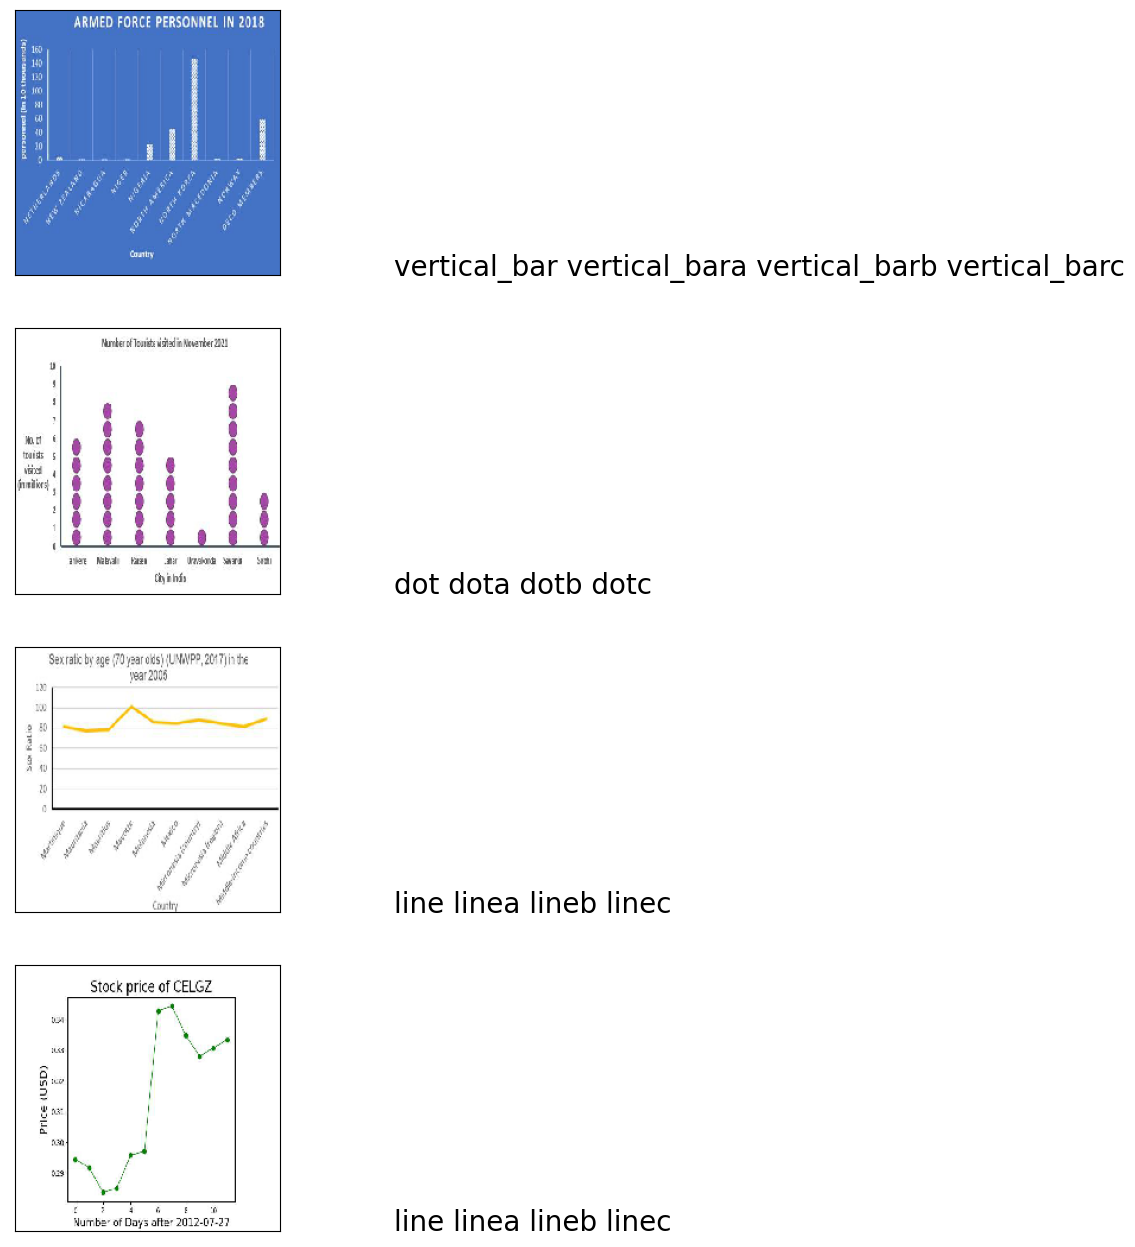

In [5]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1
image_path = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '\\' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)#.Resizing(128,128,interpolation='bilinear',crop_to_aspect_ratio=False,**kwargs)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [6]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 20


In [7]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 12


In [8]:
PATH = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images'
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  line linea lineb linec <end>',
 '<start>  line linea lineb linec <end>',
 '<start>  scatter scattera scatterb scatterc <end>',
 '<start>  line linea lineb linec <end>',
 '<start>  scatter scattera scatterb scatterc <end>',
 '<start>  dot dota dotb dotc <end>',
 '<start>  dot dota dotb dotc <end>',
 '<start>  <end>',
 '<start>  line linea lineb linec <end>',
 '<start>  line linea lineb linec <end>']

In [9]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + "\\" + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\0003a50817cf.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\0005413054c9.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\0005e64fdc6e.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\000614d3eab6.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\000631f33080.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\000917f5d829.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\000944919c5c.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\0011bb0573da.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\001221641993.jpg',
 'C:\\Users\\16032\\Downloads\\benetech-making-graphs-accessible\\train\\images\\001228841945.jpg']

In [10]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 60338
len(all_captions) : 60338


In [11]:
def data_limiter(num,total_captions,all_img_name_vector):
    train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(60000,all_captions,all_img_name_vector)

In [12]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [13]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [14]:
%%time
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 938/938 [1:15:45<00:00,  4.85s/it]

Wall time: 1h 15min 45s


In [15]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [16]:
train_captions[:3]

['<start>  line linea lineb linec <end>',
 '<start>  scatter scattera scatterb scatterc <end>',
 '<start>  line linea lineb linec <end>']

In [17]:
train_seqs[:3]

[[2, 4, 5, 6, 7, 3], [2, 8, 9, 10, 11, 3], [2, 4, 5, 6, 7, 3]]

In [18]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 6 : 2


In [19]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.5, random_state=0)

In [20]:
BATCH_SIZE = 24
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [21]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
class VGG16_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [23]:
def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [24]:
class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [26]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [27]:
EPOCHS = 50
start_epoch = 0
for epoch in range(start_epoch, EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0183
Epoch 1 Batch 100 Loss 0.0629
Epoch 1 Batch 200 Loss 0.0004
Epoch 1 Batch 300 Loss 0.0005
Epoch 1 Batch 400 Loss 0.0003
Epoch 1 Batch 500 Loss 0.0001
Epoch 1 Batch 600 Loss 0.0044
Epoch 1 Batch 700 Loss 0.0036
Epoch 1 Batch 800 Loss 0.0258
Epoch 1 Batch 900 Loss 0.0002
Epoch 1 Batch 1000 Loss 0.0004
Epoch 1 Batch 1100 Loss 0.0223
Epoch 1 Batch 1200 Loss 0.0002
Epoch 1 Loss 0.035536
Time taken for 1 epoch 127.20948052406311 sec

Epoch 2 Batch 0 Loss 0.0000
Epoch 2 Batch 100 Loss 0.0001
Epoch 2 Batch 200 Loss 0.0004
Epoch 2 Batch 300 Loss 0.0001
Epoch 2 Batch 400 Loss 0.0005
Epoch 2 Batch 500 Loss 0.0000
Epoch 2 Batch 600 Loss 0.0404
Epoch 2 Batch 700 Loss 0.0001
Epoch 2 Batch 800 Loss 0.0001
Epoch 2 Batch 900 Loss 0.0009
Epoch 2 Batch 1000 Loss 0.0242
Epoch 2 Batch 1100 Loss 0.0148
Epoch 2 Batch 1200 Loss 0.0002
Epoch 2 Loss 0.002871
Time taken for 1 epoch 108.69760203361511 sec

Epoch 3 Batch 0 Loss 0.0001
Epoch 3 Batch 100 Loss 0.0003
Epoch 3 Batch 200 Loss

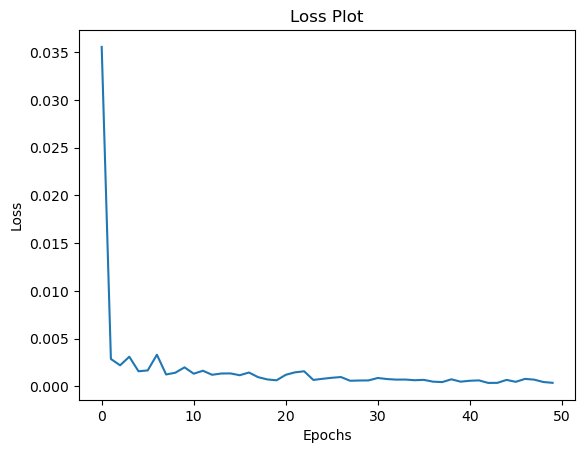

In [28]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [29]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [41]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(1, len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        #print("hello" + str(l))
        ax = fig.add_subplot(len_result//2, len_result//2, l)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

BELU score: 66.8740304976422
Real Caption: scatter scattera scatterb scatterc
Prediction Caption: scatter scattera scatterb scatterc


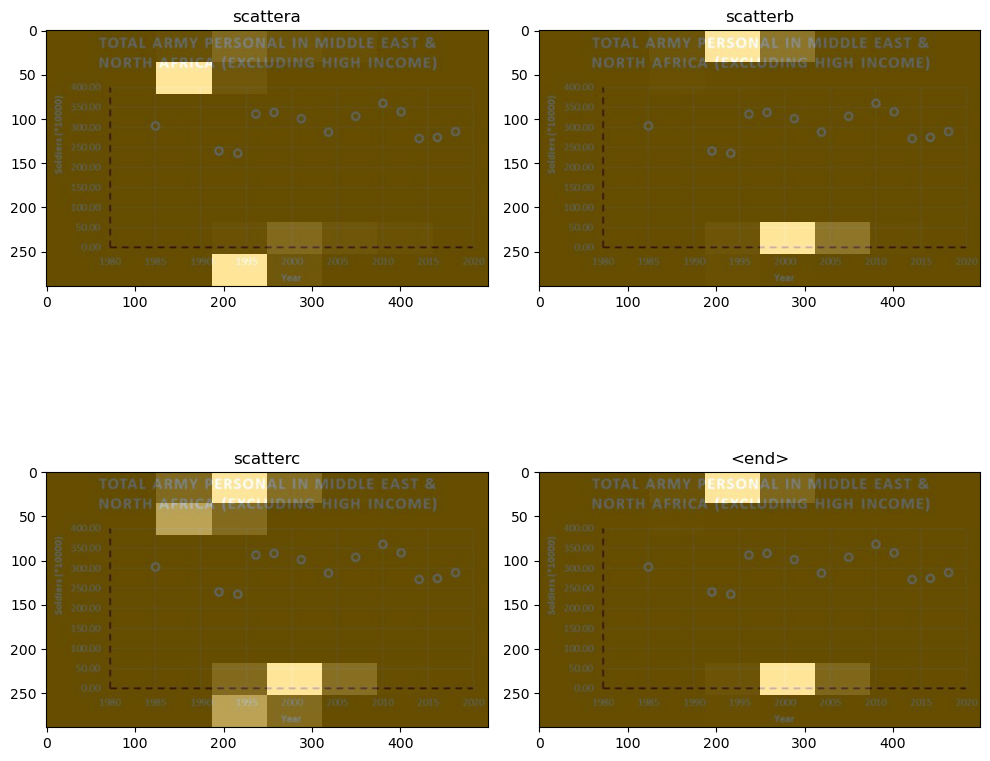

In [42]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\ffba62c94141.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'scatter scattera scatterb scatterc'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 66.8740304976422
Real Caption: line linea lineb linec
Prediction Caption: line linea lineb linec


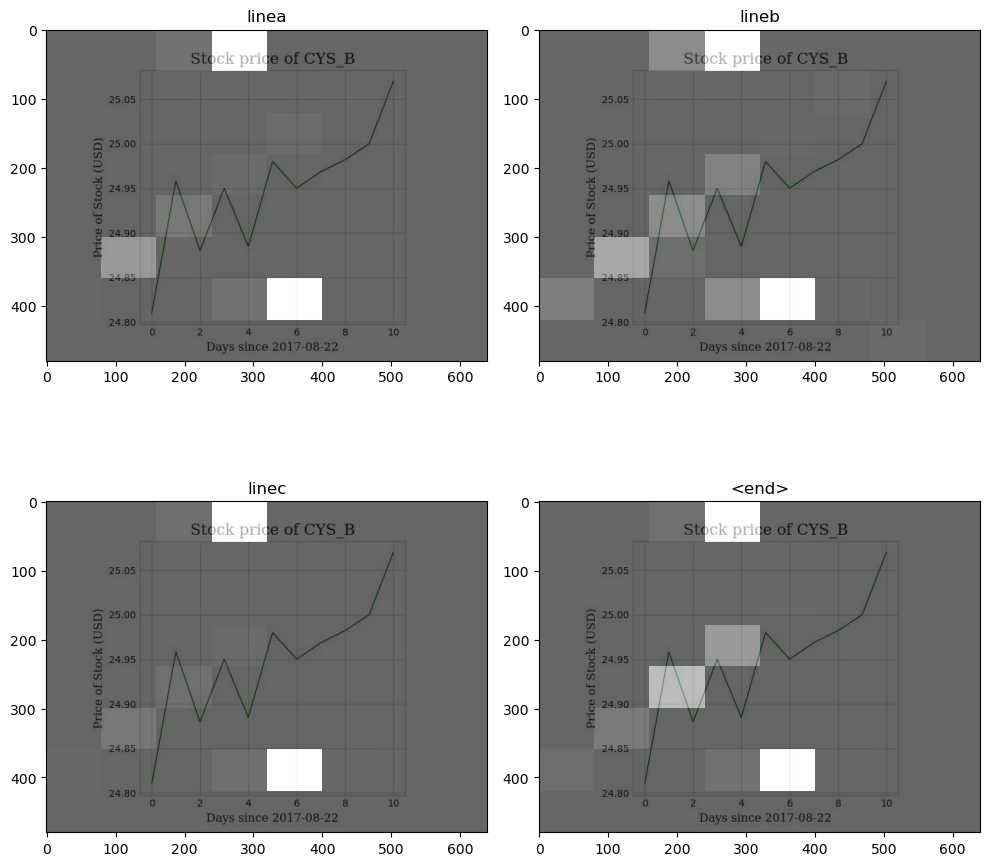

In [43]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\30a4e658c99b.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'line linea lineb linec'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 66.8740304976422
Real Caption: line linea lineb linec
Prediction Caption: line linea lineb linec


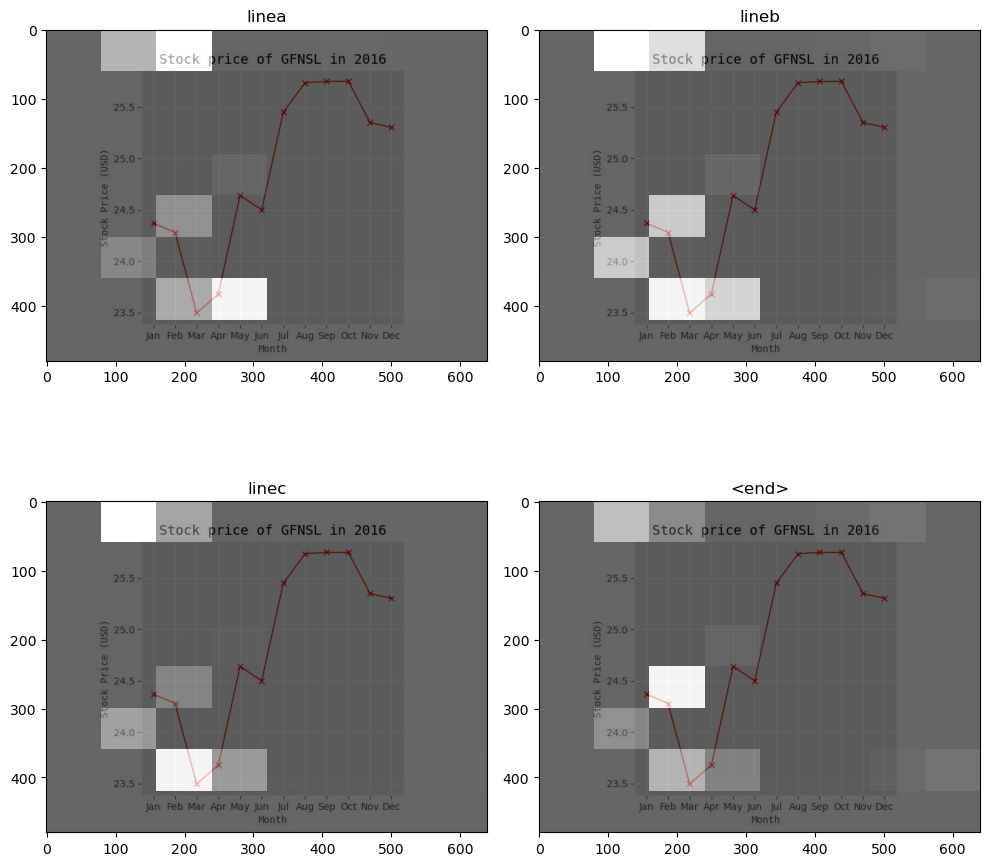

In [44]:
rid = np.random.randint(0, len(img_name_val))
image = r'C:\Users\16032\Downloads\benetech-making-graphs-accessible\train\images\869d37426a45.jpg'

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
real_caption = 'line linea lineb linec'
first = real_caption.split(' ', 1)[1]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

In [ ]:
#TODO
#EXTRACT INFO ABOUT SCATTER PLOTS
#EXTEND A PRETRAINED CAPTIONING MODEL TO CAPTION THOSE PLOTS
#DO ONE MODEL FOR EACH TYPE OF GRAPH